# Notes:

On Gurobi
*  does handle loops very well, so need to include a "dummy placeholder", otherwise gets "stuck" in a loop (when solving), but will come as 0 (is not an actual slack) is just a dumb placeholder to allow to iteract within the loop
*  it is need to disable presolve (also with loops), otherwise cannot even get interactions.
* Documentation on "heuristics" is like "it is magic", does not state what is actually doing
* does not know indicator functions or allows assignment
* more than 2000 variables (not the case, as number of variables is n Θ, n $t$ plus de "dummy" n) it is needed to set licence environment. If need pass it as parameter env.

On the Matching algo

* does handle loops very well, so need to include a "dummy placeholder", otherwise gets "stuck" in a loop (when solving), but will come as 0 (is not an actual slack) is just a dumb placeholder to allow to interact within the loop*
* it is need to desable presolve (also with loops), otherwise cannot even get interactions.

On Networks

- depending on the one used is need to check:
- MV connection is true (otherwise get orphans), if need just build from YBus from scratch
- pandapower uses also a reduced Ybus (that is a problem when it is needed same $n x n$ square matrices)

On Figures

- use kaleido to export as vector (pdf or svg)
fig.write_image("images/fig1.pdf")
fig.write_image("images/fig1.svg")
https://plotly.com/python/static-image-export/
- recall 300 bpi is standard for printing



## Data, Libraries, set-up

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/mosek.lic"

In [3]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")

In [4]:
!ls "/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data"

'=10'
 100006-0.parquet
 8500node.zip
'8500node.zip (Unzipped Files)'
 9500-Node-Model-Submission-Model-Files.zip
'9500-Node-Model-Submission-Model-Files.zip (Unzipped Files)'
 annual_solar_value_by_plant_and_county_0.xlsx
 cluster_medians_com.csv
 cluster_medians.csv
 cluster_medians_solar.csv
 edges_list.csv
 European_LV_Test_Feeder_v2.zip
'European_LV_Test_Feeder_v2.zip (Unzipped Files)'
 feeder34.zip
'feeder34.zip (Unzipped Files)'
 GSA_Report_Pittsburgh.xlsx
 gwa-plot-data_2023-09-03169376876345007_19_23_UTC.zip
 IEEE34Node.zip
 images
 median_loads_per_hour.csv
 metadata.tsv
 model.ilp
 monte_carlo_power_output_simulation.csv
 monte_carlo_simulation.csv
 network_44_WB.png
 network_80_WB.png
 network_graph.pgf
 networks_hour
'pa-pv-2006 .zip'
'pa-pv-2006 .zip (Unzipped Files)'
 pos_edges_list.csv
 slack_power_adjustments_p2p_trades.csv
 temp-plot.html
 up00-pjm-mediumoffice.csv
 up00-pjm-single-family_attached.csv
 up01-pa-mobile_home.csv
 your_problem.lp


In [5]:
!apt-get install -y graphviz libgraphviz-dev #data viz
!pip install pygraphviz diagrams # diagrams
!pip install pandapower["all"] #data
! pip install gurobipy #gurobi (MILP)
! pip install scipy #transform .m to .pp
!pip install pydot graphviz # for HG
! pip install plotly #cute plots
! pip install -U kaleido #to save png IO

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9 kB]
Get:

In [100]:
import gurobipy as gp
# Create an environment with your WLS license
params = {
"WLSACCESSID":'e83c1bc6-676d-4c3d-8bc2-0eb322fed75d',
"WLSSECRET":'96a3a8df-eefa-4bb0-9d82-13d1febddec3',
"LICENSEID":2433683,
}

env = gp.Env(params=params)

# Create the model within the Gurobi environment
m = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2433683
Academic license 2433683 - for non-commercial use only - registered to di___@andrew.cmu.edu


## Reading from already calculated clusters

In [101]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")
if not os.path.exists("images"):
    os.mkdir("images")

In [102]:
import pandas as pd
cluster_medians_solar = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data/cluster_medians_com.csv', header=0, sep=',')

In [103]:
import plotly.graph_objects as go

cluster_medians_solar["Hour"] = list(range(24))

fig = go.Figure()

# Add traces for each cluster
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_0"], mode='lines', name='Cluster_0'))
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_1"], mode='lines', name='Cluster_1'))
fig.add_trace(go.Scatter(x=cluster_medians_solar["Hour"], y=cluster_medians_solar["Cluster_2"], mode='lines', name='Cluster_2'))

# Update axes titles
fig.update_xaxes(title_text="Hour of the Day")
fig.update_yaxes(title_text="kWh")

# Update legend and layout
fig.update_layout(
    title="Daily Clusters - Solar Generation",
    font=dict(family="Times New Roman"),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right")
)

fig.write_image("images/fig1.pdf")
fig.show()

In [104]:
import plotly.graph_objects as go

cluster_medians["Hour"] = list(range(24))

fig = go.Figure()

# Add traces for each cluster
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_0"], mode='lines', name='Cluster_0'))
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_1"], mode='lines', name='Cluster_1'))
fig.add_trace(go.Scatter(x=cluster_medians["Hour"], y=cluster_medians["Cluster_2"], mode='lines', name='Cluster_2'))

# Update axes titles
fig.update_xaxes(title_text="Hour of the Day")
fig.update_yaxes(title_text="kWh")

# Update legend and layout
fig.update_layout(
    title="Daily Clusters - Loads Residencial",
    font=dict(family="Times New Roman"),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right")
)


fig.show()


In [105]:
cluster_medians_com["Hour"] = list(range(24))
#fig = px.line(cluster_medians_com, x="Hour", y=["Cluster_0", "Cluster_1"], title="Daily Clusters - Loads Commercial")
#fig.update_xaxes(title_text="Hour of the Day ")
#fig.update_yaxes(title_text="Cluster Values(kWh)")
#fig.update_layout(legend=dict(orientation="h", x=0.5, y=1.1))
#fig.show()

## Network

In [106]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting.plotly import vlevel_plotly
import plotly.io as pio


#net = pn.create_cigre_network_lv()

net = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')
#net.name = "cigre network lv"
fig = vlevel_plotly(net)
#fig.update_layout(width=800, height=600, plot_bgcolor='white',
#                  font=dict(family='Computer Modern, serif', size=12, color='black'))

fig.update_layout(width=800, height=600, plot_bgcolor='white', showlegend=False)

# Show the plot
fig.show()

# Number of buses
n_buses = len(net.bus)

/usr/local/lib/python3.10/dist-packages/pandapower/networks/synthetic_voltage_control_lv_networks.py:196: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.



In [107]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix

# Create a graph from the network
graph = pp.topology.create_nxgraph(net)

# Remove all loads and generations
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Transpose the DataFrame
transposed_df = cluster_medians.T
# Take just the first row (hour 11 for now)
first_row = transposed_df.iloc[:, 11]
#Removing previous values
net.load.drop(net.load.index, inplace=True)

# Find extreme buses (logic is that loads and sgen will be here....)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# Calculate 50% of the extreme buses
num_to_add = int(len(extreme_buses) * 0.5)

# Randomly select 50% of the extreme buses
#np.random.shuffle(extreme_buses)
#selected_buses = extreme_buses[:num_to_add]

selected_buses_odd = extreme_buses[1::2][:num_to_add]
selected_buses_even = extreme_buses[0::2][:num_to_add]
selected_buses = selected_buses_odd[:num_to_add]

# set loads on these
for bus in selected_buses_odd:
    load = first_row.iloc[1]
    q_value = np.abs(load * np.tan(np.arccos(0.99)))
    pp.create_load(net, bus=bus, p_mw=load/1e3,q_mvar=q_value/1e3) #recall that values are in MW

#Removing previous values
net.sgen.drop(net.sgen.index, inplace=True)

# Transpose the DataFrame for solar data
transposed_df_solar = cluster_medians_solar.T

# Take just the first row (hour 11 for now)
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add sgens to the selected buses using solar data
for bus in selected_buses_even:
    #solar_value = first_row_solar[1] #1st cluster
    solar_value = first_row_solar.iloc[1]
    q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3) #recall that values are in MW

In [109]:
net.load

name  bus      p_mw    q_mvar  const_z_percent  const_i_percent  sn_mva  \
0   None   12  0.002419  0.000345              0.0              0.0     NaN   
1   None   14  0.002419  0.000345              0.0              0.0     NaN   
2   None   16  0.002419  0.000345              0.0              0.0     NaN   
3   None   18  0.002419  0.000345              0.0              0.0     NaN   
4   None   36  0.002419  0.000345              0.0              0.0     NaN   
5   None   38  0.002419  0.000345              0.0              0.0     NaN   
6   None   40  0.002419  0.000345              0.0              0.0     NaN   
7   None   42  0.002419  0.000345              0.0              0.0     NaN   
8   None   44  0.002419  0.000345              0.0              0.0     NaN   
9   None   46  0.002419  0.000345              0.0              0.0     NaN   
10  None   48  0.002419  0.000345              0.0              0.0     NaN   
11  None   50  0.002419  0.000345              0.0              0.0     NaN   
12  None   57  0.002419  0.000345              0.0              0.0     NaN   
13  None   59  0.002419  0.000345              0.0              0.0     NaN   
14  None   61  0.002419  0.000345              0.0              0.0     NaN   
15  None   72  0.002419  0.000345              0.0              0.0     NaN   
16  None   74  0.002419  0.000345              0.0              0.0     NaN   
17  None   76  0.002419  0.000345              0.0              0.0     NaN   
18  None   78  0.002419  0.000345              0.0              0.0     NaN   
19  None    0  0.002419  0.000345              0.0              0.0     NaN   

    scaling  in_service type  
0       1.0        True  wye  
1       1.0        True  wye  
2       1.0        True  wye  
3       1.0        True  wye  
4       1.0        True  wye  
5       1.0        True  wye  
6       1.0        True  wye  
7       1.0        True  wye  
8       1.0        True  wye  
9       1.0        True  wye  
10      1.0        True  wye  
11      1.0        True  wye  
12      1.0        True  wye  
13      1.0        True  wye  
14      1.0        True  wye  
15      1.0        True  wye  
16      1.0        True  wye  
17      1.0        True  wye  
18      1.0        True  wye  
19      1.0        True  wye

## Calculate net surplus/deficit at each bus (generation - load)

In [110]:
import pandas as pd
import numpy as np

# Initialize dictionaries to track total traded quantities
load_traded = {node: 0 for node in net['load']['bus'].unique()}
gen_traded = {node: 0 for node in net['sgen']['bus'].unique()}

initial_gen_capacity = {node: capacity for node, capacity in zip(net['sgen']['bus'], net['sgen']['p_mw'])}
initial_load_demand = {node: demand for node, demand in zip(net['load']['bus'], net['load']['p_mw'])}

# Set fixed ask and bid prices for buyers (loads) and sellers (generators)
fixed_ask_price = 0.2  # Fixed price for buyers
fixed_bid_price = 0.05  # Fixed price for sellers

# Calculate net surplus/deficit at each bus (generation - load)
net_surplus_deficit = {node: gen - initial_load_demand.get(node, 0) for node, gen in initial_gen_capacity.items()}
net_surplus_deficit.update({node: -load for node, load in initial_load_demand.items() if node not in net_surplus_deficit})

# Generate buy orders for buses with a deficit
buy_orders = [{'node': node, 'price': fixed_ask_price, 'quantity': -deficit}
              for node, deficit in net_surplus_deficit.items() if deficit < 0]

# Generate sell orders for all buses with generation capacity
sell_orders = [{'node': node, 'price': fixed_bid_price, 'quantity': surplus}
               for node, surplus in net_surplus_deficit.items()]

# Convert orders to DataFrame and sort them
buy_orders_df = pd.DataFrame(buy_orders).sort_values(by='price')
sell_orders_df = pd.DataFrame(sell_orders).sort_values(by='price', ascending=False)


# Initialize a list to store matches for buyers
buyer_matches = []

# Initialize a list to store matches for sellers
seller_matches = []

for buy_idx, buy in buy_orders_df.iterrows():
    if buy['quantity'] <= 0:
        continue

    for sell_idx, sell in sell_orders_df.iterrows():
        if sell['quantity'] <= 0:
            continue

        if buy['node'] != sell['node'] and buy['price'] >= sell['price']:
            traded_quantity = min(buy['quantity'], sell['quantity'])

            # Update quantities
            buy_orders_df.at[buy_idx, 'quantity'] -= traded_quantity
            sell_orders_df.at[sell_idx, 'quantity'] -= traded_quantity

            # Record the match for the buyer
            buyer_matches.append((buy['node'], sell['node'], traded_quantity, sell['price']))

            # Record the match for the seller
            seller_matches.append((sell['node'], buy['node'], traded_quantity, sell['price']))

            # Check if buyer's demand is satisfied
            if buy_orders_df.at[buy_idx, 'quantity'] <= 0:
                break

# Print the matches for buyers in the new format
print("Matches for Buyers:", buyer_matches)

# Print the matches for sellers
print("Matches for Sellers:", seller_matches)

Matches for Buyers: [(12.0, 11.0, 0.0012150000000000002, 0.05), (12.0, 13.0, 0.0012150000000000002, 0.05), (76.0, 79.0, 0.0012150000000000002, 0.05), (76.0, 45.0, 0.0012150000000000002, 0.05), (74.0, 15.0, 0.0012150000000000002, 0.05), (74.0, 17.0, 0.0012150000000000002, 0.05), (72.0, 19.0, 0.0012150000000000002, 0.05), (72.0, 37.0, 0.0012150000000000002, 0.05), (61.0, 39.0, 0.0012150000000000002, 0.05), (61.0, 41.0, 0.0012150000000000002, 0.05), (59.0, 43.0, 0.0012150000000000002, 0.05), (59.0, 47.0, 0.0012150000000000002, 0.05), (57.0, 77.0, 0.0012150000000000002, 0.05), (57.0, 49.0, 0.0012150000000000002, 0.05), (50.0, 51.0, 0.0012150000000000002, 0.05), (50.0, 58.0, 0.0012150000000000002, 0.05), (48.0, 60.0, 0.0012150000000000002, 0.05), (48.0, 71.0, 0.0012150000000000002, 0.05), (46.0, 73.0, 0.0012150000000000002, 0.05), (46.0, 75.0, 0.0012150000000000002, 0.05)]
Matches for Sellers: [(11.0, 12.0, 0.0012150000000000002, 0.05), (13.0, 12.0, 0.0012150000000000002, 0.05), (79.0, 76.0

In [111]:
seller_matches

[(11.0, 12.0, 0.0012150000000000002, 0.05),
 (13.0, 12.0, 0.0012150000000000002, 0.05),
 (79.0, 76.0, 0.0012150000000000002, 0.05),
 (45.0, 76.0, 0.0012150000000000002, 0.05),
 (15.0, 74.0, 0.0012150000000000002, 0.05),
 (17.0, 74.0, 0.0012150000000000002, 0.05),
 (19.0, 72.0, 0.0012150000000000002, 0.05),
 (37.0, 72.0, 0.0012150000000000002, 0.05),
 (39.0, 61.0, 0.0012150000000000002, 0.05),
 (41.0, 61.0, 0.0012150000000000002, 0.05),
 (43.0, 59.0, 0.0012150000000000002, 0.05),
 (47.0, 59.0, 0.0012150000000000002, 0.05),
 (77.0, 57.0, 0.0012150000000000002, 0.05),
 (49.0, 57.0, 0.0012150000000000002, 0.05),
 (51.0, 50.0, 0.0012150000000000002, 0.05),
 (58.0, 50.0, 0.0012150000000000002, 0.05),
 (60.0, 48.0, 0.0012150000000000002, 0.05),
 (71.0, 48.0, 0.0012150000000000002, 0.05),
 (73.0, 46.0, 0.0012150000000000002, 0.05),
 (75.0, 46.0, 0.0012150000000000002, 0.05)]

In [112]:
buyer_matches

[(12.0, 11.0, 0.0012150000000000002, 0.05),
 (12.0, 13.0, 0.0012150000000000002, 0.05),
 (76.0, 79.0, 0.0012150000000000002, 0.05),
 (76.0, 45.0, 0.0012150000000000002, 0.05),
 (74.0, 15.0, 0.0012150000000000002, 0.05),
 (74.0, 17.0, 0.0012150000000000002, 0.05),
 (72.0, 19.0, 0.0012150000000000002, 0.05),
 (72.0, 37.0, 0.0012150000000000002, 0.05),
 (61.0, 39.0, 0.0012150000000000002, 0.05),
 (61.0, 41.0, 0.0012150000000000002, 0.05),
 (59.0, 43.0, 0.0012150000000000002, 0.05),
 (59.0, 47.0, 0.0012150000000000002, 0.05),
 (57.0, 77.0, 0.0012150000000000002, 0.05),
 (57.0, 49.0, 0.0012150000000000002, 0.05),
 (50.0, 51.0, 0.0012150000000000002, 0.05),
 (50.0, 58.0, 0.0012150000000000002, 0.05),
 (48.0, 60.0, 0.0012150000000000002, 0.05),
 (48.0, 71.0, 0.0012150000000000002, 0.05),
 (46.0, 73.0, 0.0012150000000000002, 0.05),
 (46.0, 75.0, 0.0012150000000000002, 0.05)]

# Testing extreme cases

In [113]:
extreme_added_flow = [(a, b, c * 1000, d) for a, b, c, d in seller_matches]
extreme_added_flow

[(11.0, 12.0, 1.215, 0.05),
 (13.0, 12.0, 1.215, 0.05),
 (79.0, 76.0, 1.215, 0.05),
 (45.0, 76.0, 1.215, 0.05),
 (15.0, 74.0, 1.215, 0.05),
 (17.0, 74.0, 1.215, 0.05),
 (19.0, 72.0, 1.215, 0.05),
 (37.0, 72.0, 1.215, 0.05),
 (39.0, 61.0, 1.215, 0.05),
 (41.0, 61.0, 1.215, 0.05),
 (43.0, 59.0, 1.215, 0.05),
 (47.0, 59.0, 1.215, 0.05),
 (77.0, 57.0, 1.215, 0.05),
 (49.0, 57.0, 1.215, 0.05),
 (51.0, 50.0, 1.215, 0.05),
 (58.0, 50.0, 1.215, 0.05),
 (60.0, 48.0, 1.215, 0.05),
 (71.0, 48.0, 1.215, 0.05),
 (73.0, 46.0, 1.215, 0.05),
 (75.0, 46.0, 1.215, 0.05)]

# Network state without P2P

In [114]:
# Aggregate quantities for each buyer and seller from the matches

# Initialize seller_quantities dictionary
buyer_quantities = {}
for buy in buyer_matches:
    buyer = buy[0]
    quantity = buy[2]
    buyer_quantities[buyer] = buyer_quantities.get(buyer, 0) + quantity

# Initialize seller_quantities dictionary
seller_quantities = {}
for sell in seller_matches:
    seller = sell[0]
    quantity = sell[2]
    seller_quantities[seller] = seller_quantities.get(seller, 0) + quantity

# Reduce net.load demand by the quantities bought
for node, quantity_bought in buyer_quantities.items():
    net.load.loc[net.load.bus == node, 'p_mw'] = np.maximum(net.load.loc[net.load.bus == node, 'p_mw'] - quantity_bought, 0)

# Reduce net.sgen capacity by the quantities sold
for node, quantity_sold in seller_quantities.items():
    net.sgen.loc[net.sgen.bus == node, 'p_mw'] = np.maximum(net.sgen.loc[net.sgen.bus == node, 'p_mw'] - quantity_sold, 0)


In [115]:
net.load

name  bus      p_mw    q_mvar  const_z_percent  const_i_percent  sn_mva  \
0   None   12  0.000000  0.000345              0.0              0.0     NaN   
1   None   14  0.002419  0.000345              0.0              0.0     NaN   
2   None   16  0.002419  0.000345              0.0              0.0     NaN   
3   None   18  0.002419  0.000345              0.0              0.0     NaN   
4   None   36  0.002419  0.000345              0.0              0.0     NaN   
5   None   38  0.002419  0.000345              0.0              0.0     NaN   
6   None   40  0.002419  0.000345              0.0              0.0     NaN   
7   None   42  0.002419  0.000345              0.0              0.0     NaN   
8   None   44  0.002419  0.000345              0.0              0.0     NaN   
9   None   46  0.000000  0.000345              0.0              0.0     NaN   
10  None   48  0.000000  0.000345              0.0              0.0     NaN   
11  None   50  0.000000  0.000345              0.0              0.0     NaN   
12  None   57  0.000000  0.000345              0.0              0.0     NaN   
13  None   59  0.000000  0.000345              0.0              0.0     NaN   
14  None   61  0.000000  0.000345              0.0              0.0     NaN   
15  None   72  0.000000  0.000345              0.0              0.0     NaN   
16  None   74  0.000000  0.000345              0.0              0.0     NaN   
17  None   76  0.000000  0.000345              0.0              0.0     NaN   
18  None   78  0.002419  0.000345              0.0              0.0     NaN   
19  None    0  0.002419  0.000345              0.0              0.0     NaN   

    scaling  in_service type  
0       1.0        True  wye  
1       1.0        True  wye  
2       1.0        True  wye  
3       1.0        True  wye  
4       1.0        True  wye  
5       1.0        True  wye  
6       1.0        True  wye  
7       1.0        True  wye  
8       1.0        True  wye  
9       1.0        True  wye  
10      1.0        True  wye  
11      1.0        True  wye  
12      1.0        True  wye  
13      1.0        True  wye  
14      1.0        True  wye  
15      1.0        True  wye  
16      1.0        True  wye  
17      1.0        True  wye  
18      1.0        True  wye  
19      1.0        True  wye

## Capacity (adjacency matrix)

In [116]:
import numpy as np
import pandas as pd
import math


#net_N = pn.create_cigre_network_lv()

net_N = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')


# Remove all loads and generations to start with 1
net_N.load.drop(net_N.load.index, inplace=True)
net_N.sgen.drop(net_N.sgen.index, inplace=True)
net_N.gen.drop(net_N.gen.index, inplace=True)

# Run the power flow
pp.rundcpp(net_N ) #DC

# Initialize an empty adjacency matrix
n_buses = len(net_N.bus)
adj_matrix = np.zeros((n_buses, n_buses))

# Assume a default angle of 30 degrees in radians
delta_rad = math.radians(30)

# Loop over lines to populate adjacency matrix
for i, line in net_N.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km

    v_from = net_N.res_bus.vm_pu.loc[from_bus] * net_N.bus.vn_kv.loc[from_bus]
    v_to = net_N.res_bus.vm_pu.loc[to_bus] * net_N.bus.vn_kv.loc[to_bus]

    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)

    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Loop over transformers
for i, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva

    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva


# Loop over external grid connections
for i, eg in net_N.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net_N.bus.vn_kv.loc[bus]

    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Loop over switches
for i, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)

    if switch.closed:
        if switch.et == 'l':  # Line switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 't':  # Transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch
            P_capacity_switch = 0  # Set to zero or use your custom logic
    else:
        P_capacity_switch = 0  # Open switch

    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

ext_grid_bus = net_N.ext_grid.bus.values[0]
#s_sc_max_mva = net_N.ext_grid.s_sc_max_mva.values[0]  # Assuming this is the capacity for ext_grid , if bus 80 need to comment this line
#s_sc_max_mva = 0

# Connect ext_grid to the transformers using capacity values
for i, hv_bus in enumerate(net_N.trafo.hv_bus.values):
    trafo_capacity = net_N.trafo.sn_mva.values[i]
    adj_matrix[ext_grid_bus, hv_bus] = min(s_sc_max_mva, trafo_capacity)
    adj_matrix[hv_bus, ext_grid_bus] = min(s_sc_max_mva, trafo_capacity)


# Convert to DataFrame
adj_matrix_df = pd.DataFrame(adj_matrix)
adj_matrix_array = adj_matrix_df.to_numpy()
adj_matrix.shape

/usr/local/lib/python3.10/dist-packages/pandapower/networks/synthetic_voltage_control_lv_networks.py:196: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



(80, 80)

In [117]:
adj_matrix.shape

(80, 80)

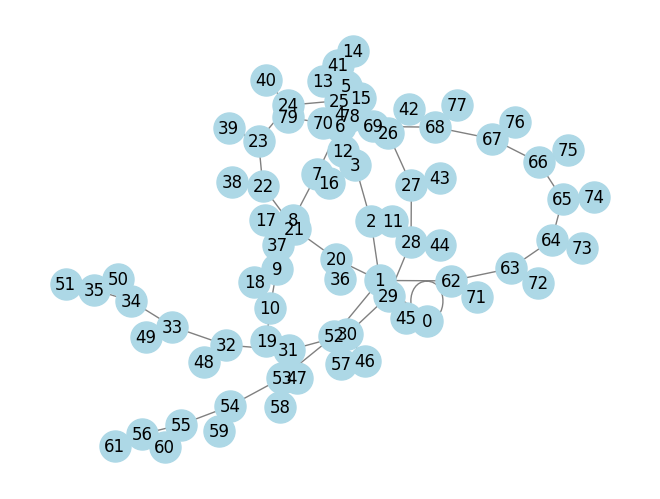

In [118]:
import networkx as nx

from matplotlib import pyplot as plt

# Create graph
G = nx.Graph(adj_matrix_array)

# Plot graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

In [69]:
import pandapower as pp
import pandapower.networks as pn
import networkx as nx
import plotly.graph_objs as go
import plotly.io as pio
from networkx.drawing.nx_agraph import graphviz_layout
import kaleido

# Create graph
G = nx.Graph(adj_matrix_array)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Extract the edges
edges_from_lines = list(net.line[['from_bus', 'to_bus']].itertuples(index=False))
edges_from_trafos = list(net.trafo[['hv_bus', 'lv_bus']].itertuples(index=False))
edges_from_switches = [(switch.bus, switch.element) for switch in net.switch[net.switch.closed].itertuples(index=False)]


# Create a new directed graph (DiGraph)
G = nx.DiGraph()

# Add the edges from lines and trafos to make it hierarchical
G.add_edges_from(edges_from_lines)
G.add_edges_from(edges_from_trafos)
G.add_edges_from(edges_from_switches)

# Modify node colors

# Remove selected buses from extreme_buses (this was calculate before to assign node, where loads to all with degree less than 1, then 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses]

# Create a dictionary to specify colors for the nodes
node_colors = {node: 'red' if node == 0 else 'green' if node in extreme_buses_1 else 'orange' if node in selected_buses else 'grey' for node in net.bus.index}

# edge colors
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
}

# Get the layout of the graph
pos = graphviz_layout(G, prog="dot")

# Manually adjust the positions of bus 0 and bus 1, 23 to create a vertical alignment
#pos[0] = (333, 810)
#pos[1] = (333, 810)
#pos[23] = (333, 810)

fig = go.Figure()

# Loop through nodes and add them to the plot, set showlegend to False
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot, set showlegend to False
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))
# Add legend with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Consumers': 'green',
    'Prosumers': 'orange',
    'iddle': 'grey'
}

# legend with colors, attribute set to True
for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=10, color=color),
                             name=label, showlegend=True))


#layout
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",  # This is a font resembles LaTeX font
                      size=18,
                      color="black"
    ))

fig.update_yaxes(scaleanchor='x', scaleratio=0.5)


# Show the plot
fig.show()

# Save the figure with high resolution
#fig.write_image("images/network_44_WB.pdf", width=800, height=600, scale=2)
fig.write_image("images/network_80_WB.pdf", width=800, height=600, scale=2)

In [119]:
import numpy as np

# Initialize Ybus as a zeros matrix
Ybus = np.zeros((n_buses,n_buses), dtype=complex)

# Iterate over lines in the network
for _, line in net.line.iterrows():
    # Get the from and to buses
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)

    # Calculate the line admittance
    z = complex(line.r_ohm_per_km, line.x_ohm_per_km)  # r and x are given per km
    y = 1 / z

    # Populate the Ybus matrix
    Ybus[from_bus][from_bus] += y
    Ybus[to_bus][to_bus] += y
    Ybus[from_bus][to_bus] -= y
    Ybus[to_bus][from_bus] -= y

# Include switches (assumed open)
for _, switch in net.switch.iterrows():
    bus = int(switch.bus)
    Ybus[bus][bus] += 1e-6  # Small admittance to represent open switch

# Include external grid (slack bus)
slack_bus = 0
Ybus[slack_bus][slack_bus] += 1e6  # Large admittance to represent external grid

# Include transformers (equivalent pi-model)
for _, trafo in net.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)


    # Manually specify transformer parameters in per unit values
    vk_percent = trafo.vk_percent
    vkr_percent = trafo.vkr_percent

    # Calculate series and shunt admittances
    z_series = complex(0, vkr_percent / 100 * vk_percent / 100)  # Assuming vk_percent and vkr_percent are given in per unit
    y_series = 1 / z_series

    # Populate the Ybus matrix
    Ybus[hv_bus][hv_bus] += y_series
    Ybus[lv_bus][lv_bus] += y_series
    Ybus[hv_bus][lv_bus] -= y_series
    Ybus[lv_bus][hv_bus] -= y_series

print(Ybus)

[[ 1.00000000e+06-2.60416667e+03j  0.00000000e+00+2.60416667e+03j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+2.60416667e+03j  1.67525773e+01-2.61060997e+03j
  -4.18814433e+00+1.61082474e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -4.18814433e+00+1.61082474e+00j
   9.90831444e+00-3.41971512e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  1.53202578e+00-1.98065638e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   1.53202578e+00-1.98065638e-01j  0.00000000e+

## Fixing Ybus

In [120]:
net_N["_ppc"]['internal']['Ybus']

orphaned_buses = set(net_N.bus.index) - set(net_N.line.from_bus) - set(net_N.line.to_bus) - set(net_N.trafo.hv_bus) - set(net_N.trafo.lv_bus)
if orphaned_buses:
    print(f"Orphaned buses detected: {orphaned_buses}")

print(net_N.ext_grid)

connected_lines = net_N.line[(net_N.line.from_bus == 0) | (net_N.line.to_bus == 0)]
print(connected_lines)

connected_trafos = net_N.trafo[(net_N.trafo.hv_bus == 0) | (net_N.trafo.lv_bus == 0)]
print(connected_trafos)

pp.create_ext_grid(net_N, bus=0, vm_pu=1.0, name="Grid Connection")
bus_hv = 0  # This is the bus where the external grid is connected.
#bus_lv = pp.create_bus(net, vn_kv=20.0, name="LV Bus")
#pp.create_transformer(net, hv_bus=bus_hv, lv_bus=bus_lv, std_type="25 MVA 110/20 kV", name="T1")

from pandapower.pypower.makeYbus import makeYbus
Ybus1, Yf, Yt = makeYbus(net_N._ppc['baseMVA'], net_N._ppc['bus'], net_N._ppc['branch'])
Ybus_dense_check = Ybus1.todense()
print(Ybus_dense_check.shape)

   name  bus  vm_pu  va_degree  slack_weight  in_service
0  None    0    1.0        0.0           1.0        True
Empty DataFrame
Columns: [name, std_type, from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, g_us_per_km, max_i_ka, df, parallel, type, in_service]
Index: []
   name               std_type  hv_bus  lv_bus  sn_mva  vn_hv_kv  vn_lv_kv  \
0  None  0.25 MVA 20/0.4 kV vc       0       1    0.25      20.0       0.4   

   vk_percent  vkr_percent  pfe_kw  i0_percent  shift_degree tap_side  \
0         4.0         0.96     0.8        0.32         150.0       hv   

   tap_neutral  tap_min  tap_max  tap_step_percent  tap_step_degree  tap_pos  \
0            0       -2        2               2.5              0.0        0   

   tap_phase_shifter  parallel   df  in_service  
0              False         1  1.0        True  
(80, 80)


# Gurobi

In [121]:
formatted_matches = seller_matches # extreme_added_flow

In [122]:
seller_matches

[(11.0, 12.0, 0.0012150000000000002, 0.05),
 (13.0, 12.0, 0.0012150000000000002, 0.05),
 (79.0, 76.0, 0.0012150000000000002, 0.05),
 (45.0, 76.0, 0.0012150000000000002, 0.05),
 (15.0, 74.0, 0.0012150000000000002, 0.05),
 (17.0, 74.0, 0.0012150000000000002, 0.05),
 (19.0, 72.0, 0.0012150000000000002, 0.05),
 (37.0, 72.0, 0.0012150000000000002, 0.05),
 (39.0, 61.0, 0.0012150000000000002, 0.05),
 (41.0, 61.0, 0.0012150000000000002, 0.05),
 (43.0, 59.0, 0.0012150000000000002, 0.05),
 (47.0, 59.0, 0.0012150000000000002, 0.05),
 (77.0, 57.0, 0.0012150000000000002, 0.05),
 (49.0, 57.0, 0.0012150000000000002, 0.05),
 (51.0, 50.0, 0.0012150000000000002, 0.05),
 (58.0, 50.0, 0.0012150000000000002, 0.05),
 (60.0, 48.0, 0.0012150000000000002, 0.05),
 (71.0, 48.0, 0.0012150000000000002, 0.05),
 (73.0, 46.0, 0.0012150000000000002, 0.05),
 (75.0, 46.0, 0.0012150000000000002, 0.05)]

In [123]:
from gurobipy import Model, GRB, quicksum, LinExpr
import numpy as np
import time

# Set Method
# -1 = automatic (default)
# 0 = primal simplex
# 1 = dual simplex
# 2 = barrier
# 3 = concurrent
# 4 = deterministic concurrent

# Create a new model
m = Model("p2p_optimization",env=env) # if more than 2000 variables need academic licence
m.setParam("Method", 2) # Set Method to Interior Point (Barrier)
m.setParam('OutputFlag', 1)
m.setParam('Presolve', 0) #have to remove presolve otherwise will mess with updates and just remove all from the start

B = np.imag(Ybus)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]
n_trades = len(formatted_matches)  # Number of P2P trades

# Define variables
theta = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")
slack_power = m.addVar(lb=-100, ub=100, name="slack_power")
x = m.addVars(len(formatted_matches), lb=0, ub=1, name="trade_vars")
#P_balance = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="P")


slack_bus_index = 0  # Define bus 0 as the slack bus
total_power_mismatch = 0
total_demand = 0
total_gen = 0

for i in range(n_buses):
    sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
    load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

    generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
    demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)

    # Adjust generation and demand based on P2P trades this is tilde_g (adjustment plus mapping)
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        if source_bus == i:
            generation_i += x[t] * quantity
        if dest_bus == i:
            demand_i += x[t] * quantity

    net_power_injection = generation_i - demand_i #this is g_0 + tilde_g as was uptdated by tilde_g
    #total_power_mismatch += net_power_injection
    total_demand += demand_i  # Increment total demand
    total_gen += generation_i  # Increment total mismatch

    power_flow_in_i = quicksum(B[i, j] * (theta[i] - theta[j]) for j in range(n_buses) if j != i)
    power_flow_out_i = quicksum(B[j, i] * (theta[j] - theta[i]) for j in range(n_buses) if j != i) #not being used

    # Apply power balance constraint for each bus
    if i != slack_bus_index:
      relax_var = m.addVar(name="dummy placeholder")
      m.addConstr(net_power_injection == power_flow_in_i - relax_var, name=f"net_power_balance_{i}")
      #m.addConstr(net_power_injection - power_flow_in_i - relax_var == 0, name=f"net_power_balance_{i}")

    if i == slack_bus_index:
        # Update the mismatch specifically for the slack bus
        slack_bus_mismatch = net_power_injection
    else:
        # Update total mismatch for all other buses
        total_power_mismatch += net_power_injection

    #g_i = generation_i - demand_i  # Initial g_i calculation or g_0

    # Adjust net generation based on P2P transactions
    #for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
    #    if source_bus == i:
    #        g_i += x[t] * quantity

    #m.addConstr(P_balance[i] == g_i , name=f"power_balance_{i}")
    #g_i = generation_i - demand_i #this is g_0 + tilde_g as was uptdated by tilde_g on each bus
    # Enforce lower bound on g_i
    #m.addConstr(g_i <= x[t] * quantity, name=f"g_upper_bound_{i}")
    #m.addConstr(g_i >= x[t] * quantity, name=f"g_lower_bound_{i}")
    #total_demand += demand_i
    #total_gen += generation_i #this is updated g
    #total_power_mismatch = generation_i - total_demand
    #total_gen = generation_i + total_power_mismatch
    #m.addConstr(P_balance[i] == g_i + power_flow_in_i, name=f"power_balance_{i}")
    #m.addConstr(P_balance[i] == 0, name=f"power_balance_{i}")

#m.addConstr(0 == g_i + power_flow_in_i, name=f"power_balance_{i}")
#m.addConstr(P_balance[i] == 0, name=f"power_balance_{i}")

# If the total mismatch is positive, the slack bus will absorb power (acts as load).
# If the total mismatch is negative, the slack bus will supply power (acts as generator).
m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance")

# Reference Bus Constraint
m.addConstr(theta[slack_bus_index] == 0)

#if needed that matrix is fine....
# Define 'lines' based on the B matrix
lines = [(i, j) for i in range(n_buses) for j in range(n_buses) if B[i, j] != 0 and i != j]
# Define line_capacity using adj_matrix
line_capacity = {(i, j): adj_matrix[i, j] for i in range(n_buses) for j in range(n_buses) if adj_matrix[i, j] != 0 and i != j}
# Line flow constraints using B matrix and theta variables
for (i, j) in lines:
    m.addConstr(B[i, j] * (theta[i] - theta[j]) <= adj_matrix[i, j], "LineCapacity" + str(i) + "_" + str(j))

# Angle difference constraints
# Power flow constraints
max_angle_diff = np.pi / 6  # 30 degrees
for i in range(n_buses):
    for j in range(n_buses):
        if i != j and B[i, j] > 0: #connection between buses i and j
            power_flow = B[i, j] * (theta[i] - theta[j])
            m.addConstr(power_flow <= adj_matrix[i, j], name=f"P_flow_max_{i}_{j}")
            m.addConstr(power_flow >= -adj_matrix[i, j], name=f"P_flow_min_{i}_{j}")
            m.addConstr(theta[i] - theta[j] <= max_angle_diff, name=f"angle_diff_max_{i}_{j}")
            m.addConstr(theta[i] - theta[j] >= -max_angle_diff, name=f"angle_diff_min_{i}_{j}")

#gurobi does not work with abs, so need to set 2 constraints

# Adding line capacity constraints
for i in range(n_buses):
    for j in range(n_buses):
        if i != j and B[i, j] != 0:
            # Constraint for the power flow not exceeding line capacity
            m.addConstr(B[i, j] * (theta[i] - theta[j]) <= line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_{i}_{j}_upper")
            m.addConstr(B[i, j] * (theta[i] - theta[j]) >= -line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_{i}_{j}_lower")

# Line flow constraints using B matrix and theta variables
for (i, j) in lines:
    power_flow = B[i, j] * (theta[i] - theta[j])
    m.addConstr(power_flow <= line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_upper_{i}_{j}")
    m.addConstr(power_flow >= -line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_lower_{i}_{j}")

# Add agreed P2P contracts constraints
for t in net['sgen'].index:
    agreed_capacity = net['sgen'].at[t, 'p_mw']
    m.addConstr(x[t] * agreed_capacity <= agreed_capacity)
    m.addConstr(x[t] * agreed_capacity >= 0)

# list to store the trade quantities
trade_quantities = [quantity for _, _, quantity, _ in formatted_matches]
objective = quicksum(trade_quantities[t] * x[t] for t in range(len(formatted_matches)))

# Set the objective function in the model
m.setObjective(objective, GRB.MAXIMIZE)

# Callback function definition
def data_cb(model, where):
    if where == GRB.Callback.BARRIER:
        cur_obj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
        runtime = time.time() - model._start
        model._data.append([runtime, cur_obj])

m._obj = None
m._bd = None
m._data = []
m._start = time.time()

m.optimize(data_cb)

# Output
if m.status == GRB.OPTIMAL or m.status == GRB.SUBOPTIMAL:

    print("Optimal solution found:")

    # Print theta values for each bus
    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")
        #print(f"Bus {i} P: {relax_var[i].X:.6f}")

    # Print trade execution levels (x[t]) along with associated quantities
    #total_executed_quantity = 0
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")
    #total_executed_quantity += executed_quantity
    # Print slack power
    print(f"Slack Power: {slack_power.X:.6f}")

    # After optimization, retrieve the objective value
    objective_value = m.ObjVal

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total load across all buses: {total_demand_value:.6f}")

if m.status == GRB.INF_OR_UNBD:
    print('Model is infeasible or unbounded')
elif m.status == GRB.INFEASIBLE:
    m.computeIIS()
    m.write("model.ilp")
    # Check the values of the slack/surplus variables
    for c in m.getConstrs():
        if c.IISConstr:
            print(f"Constraint {c.constrName} is part of the IIS.")
    for v in m.getVars():
        if v.VarName.startswith('ArtN_') or v.VarName.startswith('ArtS_'):
            if v.X > 1e-5:  # A threshold to determine if the slack variable is significant
                print(f"Constraint {v.VarName} was relaxed by {v.X}")
    # Perform a feasibility relaxation to identify which constraints are problematic
    m.feasRelaxS(0, False, False, True)
    m.optimize()
        # Print trade execution levels (x[t]) along with associated quantities
        # Print theta values for each bus

    objective_value = m.ObjVal

    print(f"Total P2P traded: {objective_value:.6f}")

    # Calculate total demand value
    total_demand_value = total_demand.getValue()

    # Sum the objective value and total demand value
    total_sum = objective_value + total_demand_value

    print(f"Total invariable load across all buses: {total_sum:.6f}")

    for i in range(n_buses):
        print(f"Bus {i} Theta: {theta[i].X:.6f}")

        # Print P variable value for each bus
    for i in range(n_buses):
       print(f"Bus {i} P: {relax_var[i].X:.6f}")
    for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
        executed_quantity = x[t].X * quantity
        print(f"Trade {t}: Execution level (x[{t}]): {x[t].X:.6f}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")

    print('Model is infeasible')
elif m.status == GRB.UNBOUNDED:
    print('Model is unbounded')
else:
    print(f'Optimization was stopped with status {m.status}')

Set parameter Method to value 2
Set parameter Presolve to value 0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2433683 - for non-commercial use only - registered to di___@andrew.cmu.edu
Optimize a model with 1543 rows, 180 columns and 3201 nonzeros
Model fingerprint: 0x94fb5c98
Coefficient statistics:
  Matrix range     [1e-03, 3e+03]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+02]
  RHS range        [2e-03, 1e+00]
Ordering time: 0.02s

Barrier statistics:
 Free vars  : 64
 AA' NZ     : 5.791e+04
 Factor NZ  : 6.619e+04 (roughly 1 MB of memory)
 Factor Ops : 3.162e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.08103139e+0

In [124]:
    # For net_power_balance constraints
    for bus_id in [36, 22,23]:
        sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == bus_id]
        load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == bus_id]

        generation = sum(net.sgen.at[t, 'p_mw'] * x[t].X for t in sgen_indices)
        demand = sum(net.load.at[t, 'p_mw'] for t in load_indices)
        net_power_injection = generation - demand

        #power_flow_out = sum(B[bus_id, j] * (theta[bus_id].X - theta[j].X) for j in range(n_buses) if j != bus_id)
        #power_flow_in = sum(B[j, bus_id] * (theta[j].X - theta[bus_id].X) for j in range(n_buses) if j != bus_id)

    #    print(f"Bus {bus_id} Net Power Balance: Generation - Demand + Power In - Power Out = {net_power_injection + power_flow_in - power_flow_out}")

    # For transit_power_balance constraint
    bus_id = 20
    #transit_bus_power_in = sum(B[bus_id, j] * (theta[bus_id].X - theta[j].X) for j in range(n_buses) if j != bus_id)
    #transit_bus_power_out = sum(B[j, bus_id] * (theta[j].X - theta[bus_id].X) for j in range(n_buses) if j != bus_id)

   # print(f"Bus {bus_id} Transit Power Balance: Power In - Power Out = {transit_bus_power_in - transit_bus_power_out}")


In [125]:
for i in range(n_buses):
    if i == 1 or i == 0 or i == 43:
        print(f"Bus {i} Power Balance Details:")
        # Assuming `generation_i` and `demand_i` are Gurobi expressions.
        print(f"Generation_i: {generation_i.getValue()}")
        print(f"Demand_i: {demand_i.getValue()}")

Bus 0 Power Balance Details:
Generation_i: 0.0012150000000000002
Demand_i: 0.0
Bus 1 Power Balance Details:
Generation_i: 0.0012150000000000002
Demand_i: 0.0
Bus 43 Power Balance Details:
Generation_i: 0.0012150000000000002
Demand_i: 0.0


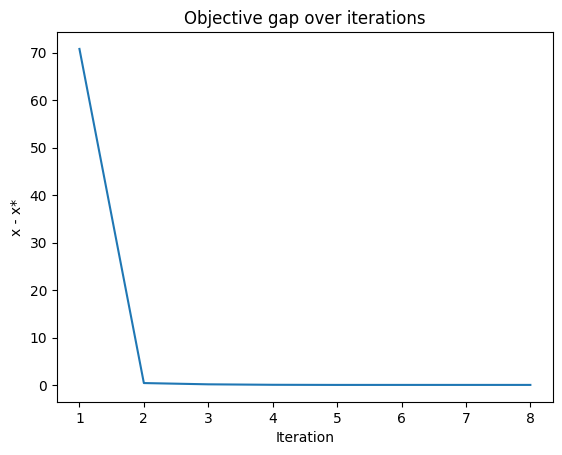

In [126]:
import matplotlib.pyplot as plt

m_data = m._data
# Extract time and objective values
times = [x[0] for x in m_data]
objs = [x[1] for x in m_data]

# Assuming x* is the final objective value
x_star = objs[-1]

# Calculate x - x* for each iteration
gap = [x - x_star for x in objs]

# Iteration count
iterations = list(range(1, len(objs) + 1))

# Create the plot
plt.plot(iterations, objs)
plt.xlabel('Iteration')
plt.ylabel('x - x*')
plt.title('Objective gap over iterations')
plt.show()

In [127]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=gap , mode='lines+markers', name='Solution Values'))
fig.update_layout(title='Objective gap over iterations',
                   xaxis_title='Iteration',
                   yaxis_title='x - x*',
                  font=dict(family="Times New Roman"),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right"))

fig.write_image("images/it_gap.pdf")
fig.show()

In [128]:
for constr in m.getConstrs():
    print(constr.ConstrName, m.getRow(constr))

net_power_balance_1 2604.166666666667 theta[0] + -2610.609965635739 theta[1] + 1.6108247422680413 theta[2] + 1.6108247422680413 theta[20] + 1.6108247422680413 theta[52] + 1.6108247422680413 theta[62] + dummy placeholder
net_power_balance_2 1.6108247422680413 theta[1] + -3.419715123011407 theta[2] + 1.6108247422680413 theta[3] + 0.19806563847532416 theta[11] + dummy placeholder
net_power_balance_3 1.6108247422680413 theta[2] + -3.419715123011407 theta[3] + 1.6108247422680413 theta[4] + 0.19806563847532416 theta[12] + dummy placeholder
net_power_balance_4 1.6108247422680413 theta[3] + -3.419715123011407 theta[4] + 1.6108247422680413 theta[5] + 0.19806563847532416 theta[13] + dummy placeholder
net_power_balance_5 1.6108247422680413 theta[4] + -3.419715123011407 theta[5] + 1.6108247422680413 theta[6] + 0.19806563847532416 theta[14] + dummy placeholder
net_power_balance_6 1.6108247422680413 theta[5] + -3.419715123011407 theta[6] + 1.6108247422680413 theta[7] + 0.19806563847532416 theta[15] 

In [129]:
import numpy as np
from scipy.sparse import dok_matrix

# model variables and constraints
n_vars = m.NumVars
n_constrs = m.NumConstrs

# Initialize A matrix as a sparse DOK matrix, B and C vectors
A = dok_matrix((n_constrs, n_vars), dtype=np.float32)
b = np.zeros(n_constrs, dtype=np.float32)
c = np.zeros(n_vars, dtype=np.float32)

# Create mapping from variable name to index
var_dict = {var.VarName: index for index, var in enumerate(m.getVars())}

# Populate B vector and A matrix
for i, constr in enumerate(m.getConstrs()):
    b[i] = constr.RHS
    expr = m.getRow(constr)
    for j in range(expr.size()):
        var = expr.getVar(j)
        coeff = expr.getCoeff(j)
        var_index = var_dict[var.VarName]
        A[i, var_index] = coeff

# Populate C
for i, var in enumerate(m.getVars()):
    c[i] = var.Obj

# Convert A to a CSR matrix
A = A.tocsr()

In [130]:
A = A.toarray()
print("Shape of A:", A.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)

Shape of A: (1543, 180)
Shape of b: (1543,)
Shape of c: (180,)


# Updating network state with validated $q_t$

In [131]:
for t, (source_bus, dest_bus, quantity, _) in enumerate(formatted_matches):
  executed_quantity = x[t].X  * quantity
  #Update generation at source bus
  net.sgen.loc[net.sgen['bus'] == source_bus, 'p_mw'] += executed_quantity

  # Update load at destination bus
  net.load.loc[net.load['bus'] == dest_bus, 'p_mw'] += executed_quantity

In [132]:
import pandapower as pp
pp.rundcpp(net) #DC

Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [133]:
net.res_bus

vm_pu   va_degree      p_mw  q_mvar
0     1.0    0.000000 -0.021769     NaN
1     1.0 -150.193734  0.000000     NaN
2     1.0 -150.199218  0.000000     NaN
3     1.0 -150.206546  0.000000     NaN
4     1.0 -150.210184  0.000000     NaN
5     1.0 -150.215667  0.000000     NaN
6     1.0 -150.217478  0.000000     NaN
7     1.0 -150.221134  0.000000     NaN
8     1.0 -150.221117  0.000000     NaN
9     1.0 -150.222944  0.000000     NaN
10    1.0 -150.221100  0.000000     NaN
11    1.0 -150.198459 -0.001215     NaN
12    1.0 -150.208062  0.002430     NaN
13    1.0 -150.209426 -0.001215     NaN
14    1.0 -150.217177  0.002419     NaN
15    1.0 -150.216720 -0.001215     NaN
16    1.0 -150.222643  0.002419     NaN
17    1.0 -150.220358 -0.001215     NaN
18    1.0 -150.224454  0.002419     NaN
19    1.0 -150.220341 -0.001215     NaN
20    1.0 -150.203147  0.000000     NaN
21    1.0 -150.210204  0.000000     NaN
22    1.0 -150.218445  0.000000     NaN
23    1.0 -150.224329  0.000000     NaN
24    1.0 -150.231397  0.000000     NaN
25    1.0 -150.236109  0.000000     NaN
26    1.0 -150.242004  0.000000     NaN
27    1.0 -150.245544  0.000000     NaN
28    1.0 -150.250267  0.000000     NaN
29    1.0 -150.252634  0.000000     NaN
30    1.0 -150.256184  0.000000     NaN
31    1.0 -150.257367  0.000000     NaN
32    1.0 -150.259734  0.000000     NaN
33    1.0 -150.259734  0.000000     NaN
34    1.0 -150.260918  0.000000     NaN
35    1.0 -150.259734  0.000000     NaN
36    1.0 -150.204657  0.002419     NaN
37    1.0 -150.209446 -0.001215     NaN
38    1.0 -150.219954  0.002419     NaN
39    1.0 -150.223571 -0.001215     NaN
40    1.0 -150.232907  0.002419     NaN
41    1.0 -150.235351 -0.001215     NaN
42    1.0 -150.243514  0.002419     NaN
43    1.0 -150.244785 -0.001215     NaN
44    1.0 -150.251776  0.002419     NaN
45    1.0 -150.251875 -0.001215     NaN
46    1.0 -150.257701  0.002430     NaN
47    1.0 -150.256609 -0.001215     NaN
48    1.0 -150.261251  0.002430     NaN
49    1.0 -150.258976 -0.001215     NaN
50    1.0 -150.262434  0.002430     NaN
51    1.0 -150.258976 -0.001215     NaN
52    1.0 -150.204873  0.000000     NaN
53    1.0 -150.210442  0.000000     NaN
54    1.0 -150.218796  0.000000     NaN
55    1.0 -150.221580  0.000000     NaN
56    1.0 -150.227149  0.000000     NaN
57    1.0 -150.206389  0.002430     NaN
58    1.0 -150.209684 -0.001215     NaN
59    1.0 -150.220312  0.002430     NaN
60    1.0 -150.220822 -0.001215     NaN
61    1.0 -150.228666  0.002430     NaN
62    1.0 -150.197898  0.000000     NaN
63    1.0 -150.203455  0.000000     NaN
64    1.0 -150.206226  0.000000     NaN
65    1.0 -150.210390  0.000000     NaN
66    1.0 -150.211770  0.000000     NaN
67    1.0 -150.214542  0.000000     NaN
68    1.0 -150.214529  0.000000     NaN
69    1.0 -150.215908  0.000000     NaN
70    1.0 -150.214516  0.000000     NaN
71    1.0 -150.197140 -0.001215     NaN
72    1.0 -150.204971  0.002430     NaN
73    1.0 -150.205468 -0.001215     NaN
74    1.0 -150.211907  0.002430     NaN
75    1.0 -150.211012 -0.001215     NaN
76    1.0 -150.216058  0.002430     NaN
77    1.0 -150.213770 -0.001215     NaN
78    1.0 -150.217418  0.002419     NaN
79    1.0 -150.213758 -0.001215     NaN

In [488]:
## ED

from gurobipy import Model, GRB, quicksum, LinExpr

B = np.imag(Ybus)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]
n_trades = len(formatted_matches)  # Number of P2P trades

model = Model("MaximizeSpecificGenerators")

# Trade/generator variables
x = model.addVars(len(formatted_matches), lb=0, ub=1, name="trade_vars")

# Voltage angle variables
theta = model.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")

# Collect all target generator indices
all_target_generators = set()
for i in range(n_buses):
    sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
    all_target_generators.update(sgen_indices)


# Define neighbors using the B matrix
neighbors = {i: [] for i in range(n_buses)}
for i in range(n_buses):
    for j in range(n_buses):
        if B[i, j] != 0 and i != j:
            neighbors[i].append(j)


# Power balance constraints for each bus
for i in range(n_buses):
    sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
    load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

    generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
    demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)

    # Adjust generation based on formatted_matches
    for t, (source_bus, _, quantity, _) in enumerate(formatted_matches):
        if source_bus == i:
            generation_i += x[t] * quantity

    # Power balance constraint for bus i
    model.addConstr(sum(B[i, j] * (theta[i] - theta[j]) for j in neighbors[i]) + generation_i == demand_i, "PowerBalance"+str(i))

# Define 'lines' based on the B matrix
lines = [(i, j) for i in range(n_buses) for j in range(n_buses) if B[i, j] != 0 and i != j]
# Define line_capacity using adj_matrix
line_capacity = {(i, j): adj_matrix[i, j] for i in range(n_buses) for j in range(n_buses) if adj_matrix[i, j] != 0 and i != j}


# Line flow constraints using B matrix and theta variables
for (i, j) in lines:
    model.addConstr(B[i, j] * (theta[i] - theta[j]) <= adj_matrix[i, j], "LineCapacity" + str(i) + "_" + str(j))

# Define Pmin and Pmax based on formatted_matches
Pmin = [0 for _ in formatted_matches]  # Minimum limits are 0
Pmax = [quantity for _, (_, _, quantity, _) in enumerate(formatted_matches)]  # Maximum limits from formatted_matches

# Generator limits constraints
for t in range(len(formatted_matches)):
    model.addConstr(x[t] >= Pmin[t], "MinGen" + str(t))
    model.addConstr(x[t] <= Pmax[t], "MaxGen" + str(t))

model.setObjective(quicksum(x[t] * quantity for t, (_, _, quantity, _) in enumerate(formatted_matches)), GRB.MAXIMIZE)


# Solve the model
model.optimize()

# Print output levels for each generator/trade
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found. Output levels:")
    for t, (_, _, quantity, _) in enumerate(formatted_matches):
        output_level = x[t].X  # Get the optimized value of x[t]
        print(f"Generator/Trade {t}: Output Level = {output_level:.2f} (Max Capacity: {quantity})")
else:
    print("Optimal solution not found. Status:", model.status)



Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 136 rows, 50 columns and 301 nonzeros
Model fingerprint: 0xb012261a
Coefficient statistics:
  Matrix range     [1e-03, 2e+03]
  Objective range  [1e-03, 1e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+00]
Presolve removed 133 rows and 48 columns
Presolve time: 0.01s
Presolved: 3 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 1

Solved in 3 iterations and 0.02 seconds (0.00 work units)
Infeasible model
Optimal solution not found. Status: 3
